<a href="https://colab.research.google.com/github/RicardoMourao-py/CNN-ALZHEIMER-CLASSIFICATION/blob/main/main_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import auth
# from google.cloud import storage
import warnings
warnings.filterwarnings('ignore')

import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# !unzip data_slices/VeryMildDemented.zip
!unzip dataset.zip

Archive:  dataset.zip
   creating: Alzheimer_s Dataset/MildDemented/
  inflating: Alzheimer_s Dataset/MildDemented/26 (19).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/26 (20).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/26 (21).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/26 (22).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/26 (23).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/26 (24).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/26 (25).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/26 (26).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/26 (27).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/26 (28).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/26.jpg  
  inflating: Alzheimer_s Dataset/MildDemented/27 (10).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/27 (11).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/27 (12).jpg  
  inflating: Alzheimer_s Dataset/MildDemented/27 (13).jpg  
  inflating: Alzheimer_s Dataset/Mil

In [ ]:
folder = './Alzheimer_s Dataset/'
folder_path = pathlib.Path(folder)

## Visualizando Imagem

<PIL.Image.Image image mode=RGB size=176x208 at 0x7AFDC312A2C0>


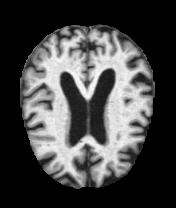

In [ ]:
photo = load_img('./Alzheimer_s Dataset/MildDemented/26 (19).jpg')
print(photo)
photo

## Imagens e suas Classificações

In [ ]:
for file in listdir(folder):
    print(file)

NonDemented
MildDemented
ModerateDemented
VeryMildDemented
Untitled Folder


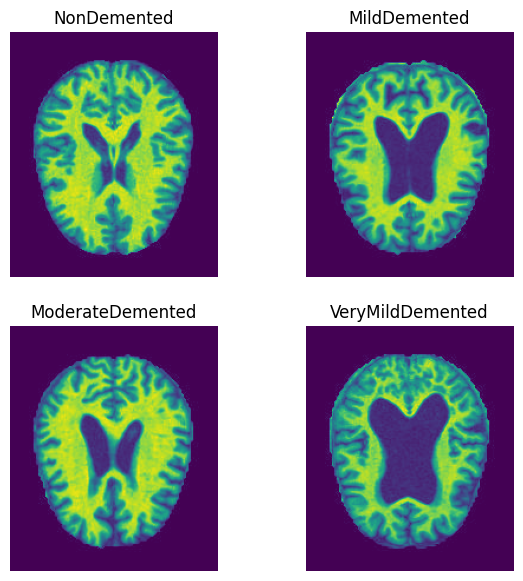

In [ ]:
plt.figure(figsize=(7,7),)
j =0
for file in listdir(folder):
    i =0
    for image in listdir(folder+'/'+file):
        if i ==1:
            break;
        img = imread(folder +'/' + file + '/' + image)
        ax = plt.subplot(2,2,j+1)
        plt.imshow(img)
        plt.title(file)
        plt.axis('off')
        j = j+1
        i = i +1
plt.show()

In [ ]:
# counting the number of images in each category
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        i = i +1
    print(file , i)

NonDemented 3200
MildDemented 896
ModerateDemented 64
VeryMildDemented 2240
Untitled Folder 0


## Image Generator

In [ ]:
# Criando o gerador de dados de imagem para ter mais amostras

IMG_SIZE = 128                  # tamanho da imagem de saída após o pré-processamento e aumento de dados
DIM = (IMG_SIZE, IMG_SIZE)      # tupla que especifica as dimensões da imagem de saída

ZOOM = [.99, 1.01]              # zoom que será aplicada às imagens
BRIGHT_RANGE = [0.8, 1.2]       #  ajuste de brilho
HORZ_FLIP = True                # espelhamento horizontal
FILL_MODE = "constant"          # pixels adicionados durante o redimensionamento serão preenchidos com um valor constante
DATA_FORMAT = "channels_last"   # formato dos dados é (altura, largura, canais)

In [ ]:
# Gerador de dados de treinamento com aumento de dados e suas normalizações
train_generator = ImageDataGenerator(
                                      rescale = 1./255,
                                      brightness_range=BRIGHT_RANGE,
                                      zoom_range=ZOOM,
                                      data_format=DATA_FORMAT,
                                      fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP
                                    )

train_data_gen = train_generator.flow_from_directory(
                                                      directory=folder,
                                                      target_size=DIM,
                                                      batch_size=6500,
                                                      shuffle=False
                                                    )

Found 6400 images belonging to 5 classes.


In [ ]:
CLASSES = list(train_data_gen.class_indices.keys())

# def show_images(generator,y_pred=None):
#     # get image lables
#     labels =dict(zip([0,1,2,3], CLASSES))

#     # get a batch of images
#     x,y = generator.next()

#     # display a grid of 9 images
#     plt.figure(figsize=(7, 7))
#     if y_pred is None:
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             idx = randint(0, 6400)
#             plt.imshow(x[idx])
#             plt.axis("off")
#             plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
#     else:
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(x[i])
#             plt.axis("off")
#             plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

# # Display Train Images
# show_images(train_data_gen)

In [ ]:
# retorna o próximo lote de dados e suas respectivas etiquetas.
train_data, train_labels = train_data_gen.next()

In [ ]:
train_data.shape, train_labels.shape

((6400, 128, 128, 3), (6400, 5))

In [ ]:
# O SMOTE é uma técnica comumente usada para lidar com conjuntos de dados de classificação que
# têm classes minoritárias com menos exemplos do que as classes majoritárias.
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(12800, 49152) (12800, 4)


In [ ]:
# alterar as dimensões de um array sem alterar os dados em si
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 128, 128, 3) (12800, 4)


In [ ]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
# Defining convolutional blocks
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())

    return block

In [ ]:
# defining dense blocks
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [ ]:
IMAGE_SIZE = [128,128]
act = 'relu'

In [ ]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')
    ], name = "cnn_model")

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 32, 32, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 128)         221952    
                                                         

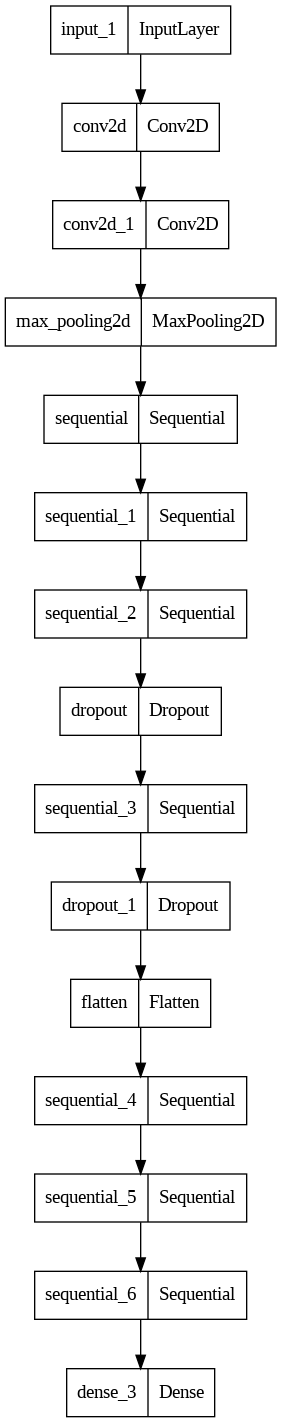

In [ ]:
plot_model(model)

In [ ]:
CALLBACKS = [
    EarlyStopping(monitor='accuracy', min_delta=0.01, patience=5, mode='max')
]

In [ ]:
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,callbacks=CALLBACKS)

Epoch 1/50
254/256 [============================>.] - ETA: 0s - loss: 1.4875 - acc: 0.3818 - auc: 0.6553 - f1_score: 0.3765

256/256 [==============================] - 22s 26ms/step - loss: 1.4866 - acc: 0.3829 - auc: 0.6557 - f1_score: 0.3778 - val_loss: 5.5489 - val_acc: 0.2402 - val_auc: 0.5028 - val_f1_score: 0.0969
Epoch 2/50
256/256 [==============================] - ETA: 0s - loss: 0.9322 - acc: 0.5758 - auc: 0.8433 - f1_score: 0.5660

256/256 [==============================] - 6s 22ms/step - loss: 0.9322 - acc: 0.5758 - auc: 0.8433 - f1_score: 0.5660 - val_loss: 1.6377 - val_acc: 0.2817 - val_auc: 0.5716 - val_f1_score: 0.2301
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 0.8211 - acc: 0.6176 - auc: 0.8747 - f1_score: 0.6088

256/256 [==============================] - 6s 23ms/step - loss: 0.8211 - acc: 0.6176 - auc: 0.8747 - f1_score: 0.6088 - val_loss: 2.4942 - val_acc: 0.2788 - val_auc: 0.5917 - val_f1_score: 0.1697
Epoch 4/50
255/256 [============================>.] - ETA: 0s - loss: 0.7180 - acc: 0.6674 - auc: 0.9040 - f1_score: 0.6609

256/256 [==============================] - 6s 22ms/step - loss: 0.7191 - acc: 0.6670 - auc: 0.9037 - f1_score: 0.6604 - val_loss: 0.8282 - val_acc: 0.6152 - val_auc: 0.8726 - val_f1_score: 0.5871
Epoch 5/50
255/256 [============================>.] - ETA: 0s - loss: 0.6539 - acc: 0.7007 - auc: 0.9210 - f1_score: 0.6977

256/256 [==============================] - 5s 19ms/step - loss: 0.6546 - acc: 0.7006 - auc: 0.9208 - f1_score: 0.6976 - val_loss: 4.0803 - val_acc: 0.2456 - val_auc: 0.5280 - val_f1_score: 0.1098
Epoch 6/50
256/256 [==============================] - ETA: 0s - loss: 0.6115 - acc: 0.7234 - auc: 0.9309 - f1_score: 0.7222

256/256 [==============================] - 6s 23ms/step - loss: 0.6115 - acc: 0.7234 - auc: 0.9309 - f1_score: 0.7222 - val_loss: 1.5592 - val_acc: 0.4775 - val_auc: 0.7794 - val_f1_score: 0.3993
Epoch 7/50
254/256 [============================>.] - ETA: 0s - loss: 0.5534 - acc: 0.7518 - auc: 0.9432 - f1_score: 0.7512

256/256 [==============================] - 6s 23ms/step - loss: 0.5536 - acc: 0.7516 - auc: 0.9432 - f1_score: 0.7509 - val_loss: 1.0720 - val_acc: 0.5596 - val_auc: 0.8190 - val_f1_score: 0.5810
Epoch 8/50
254/256 [============================>.] - ETA: 0s - loss: 0.5359 - acc: 0.7594 - auc: 0.9468 - f1_score: 0.7589

256/256 [==============================] - 6s 22ms/step - loss: 0.5356 - acc: 0.7600 - auc: 0.9469 - f1_score: 0.7597 - val_loss: 0.5632 - val_acc: 0.7363 - val_auc: 0.9387 - val_f1_score: 0.7407
Epoch 9/50
254/256 [============================>.] - ETA: 0s - loss: 0.4962 - acc: 0.7760 - auc: 0.9543 - f1_score: 0.7753

256/256 [==============================] - 5s 20ms/step - loss: 0.4971 - acc: 0.7755 - auc: 0.9541 - f1_score: 0.7750 - val_loss: 0.4886 - val_acc: 0.7876 - val_auc: 0.9561 - val_f1_score: 0.7799
Epoch 10/50
256/256 [==============================] - ETA: 0s - loss: 0.4395 - acc: 0.8092 - auc: 0.9638 - f1_score: 0.8088

256/256 [==============================] - 6s 22ms/step - loss: 0.4395 - acc: 0.8092 - auc: 0.9638 - f1_score: 0.8088 - val_loss: 0.9503 - val_acc: 0.6006 - val_auc: 0.8686 - val_f1_score: 0.6069
Epoch 11/50
254/256 [============================>.] - ETA: 0s - loss: 0.4045 - acc: 0.8244 - auc: 0.9690 - f1_score: 0.8243

256/256 [==============================] - 5s 21ms/step - loss: 0.4043 - acc: 0.8246 - auc: 0.9691 - f1_score: 0.8244 - val_loss: 3.0605 - val_acc: 0.5000 - val_auc: 0.7500 - val_f1_score: 0.3739
Epoch 12/50
256/256 [==============================] - ETA: 0s - loss: 0.4175 - acc: 0.8187 - auc: 0.9671 - f1_score: 0.8188

256/256 [==============================] - 5s 20ms/step - loss: 0.4175 - acc: 0.8187 - auc: 0.9671 - f1_score: 0.8188 - val_loss: 0.3965 - val_acc: 0.8218 - val_auc: 0.9697 - val_f1_score: 0.8162
Epoch 13/50
254/256 [============================>.] - ETA: 0s - loss: 0.3582 - acc: 0.8452 - auc: 0.9756 - f1_score: 0.8451

256/256 [==============================] - 6s 22ms/step - loss: 0.3578 - acc: 0.8455 - auc: 0.9757 - f1_score: 0.8453 - val_loss: 1.0697 - val_acc: 0.5884 - val_auc: 0.8634 - val_f1_score: 0.5917
Epoch 14/50
256/256 [==============================] - ETA: 0s - loss: 0.3602 - acc: 0.8518 - auc: 0.9757 - f1_score: 0.8519

256/256 [==============================] - 5s 20ms/step - loss: 0.3602 - acc: 0.8518 - auc: 0.9757 - f1_score: 0.8519 - val_loss: 0.4692 - val_acc: 0.7939 - val_auc: 0.9619 - val_f1_score: 0.7989
Epoch 15/50
256/256 [==============================] - ETA: 0s - loss: 0.3131 - acc: 0.8757 - auc: 0.9813 - f1_score: 0.8757

256/256 [==============================] - 6s 23ms/step - loss: 0.3131 - acc: 0.8757 - auc: 0.9813 - f1_score: 0.8757 - val_loss: 0.5506 - val_acc: 0.7847 - val_auc: 0.9528 - val_f1_score: 0.7682
Epoch 16/50
256/256 [==============================] - ETA: 0s - loss: 0.2986 - acc: 0.8851 - auc: 0.9830 - f1_score: 0.8852

256/256 [==============================] - 5s 20ms/step - loss: 0.2986 - acc: 0.8851 - auc: 0.9830 - f1_score: 0.8852 - val_loss: 1.2517 - val_acc: 0.6211 - val_auc: 0.8585 - val_f1_score: 0.5783
Epoch 17/50
256/256 [==============================] - ETA: 0s - loss: 0.2663 - acc: 0.9015 - auc: 0.9863 - f1_score: 0.9016

256/256 [==============================] - 6s 22ms/step - loss: 0.2663 - acc: 0.9015 - auc: 0.9863 - f1_score: 0.9016 - val_loss: 1.2022 - val_acc: 0.6475 - val_auc: 0.8774 - val_f1_score: 0.6206
Epoch 18/50
255/256 [============================>.] - ETA: 0s - loss: 0.2364 - acc: 0.9110 - auc: 0.9892 - f1_score: 0.9110

256/256 [==============================] - 6s 24ms/step - loss: 0.2365 - acc: 0.9110 - auc: 0.9892 - f1_score: 0.9110 - val_loss: 0.7654 - val_acc: 0.7231 - val_auc: 0.9391 - val_f1_score: 0.6788
Epoch 19/50
255/256 [============================>.] - ETA: 0s - loss: 0.2075 - acc: 0.9237 - auc: 0.9916 - f1_score: 0.9235

256/256 [==============================] - 5s 21ms/step - loss: 0.2073 - acc: 0.9237 - auc: 0.9916 - f1_score: 0.9236 - val_loss: 0.2851 - val_acc: 0.8882 - val_auc: 0.9856 - val_f1_score: 0.8876
Epoch 20/50
255/256 [============================>.] - ETA: 0s - loss: 0.1828 - acc: 0.9358 - auc: 0.9931 - f1_score: 0.9357

256/256 [==============================] - 5s 21ms/step - loss: 0.1832 - acc: 0.9357 - auc: 0.9930 - f1_score: 0.9355 - val_loss: 0.3272 - val_acc: 0.8735 - val_auc: 0.9821 - val_f1_score: 0.8702
Epoch 21/50
255/256 [============================>.] - ETA: 0s - loss: 0.2236 - acc: 0.9152 - auc: 0.9901 - f1_score: 0.9150

256/256 [==============================] - 5s 20ms/step - loss: 0.2241 - acc: 0.9150 - auc: 0.9901 - f1_score: 0.9149 - val_loss: 0.7073 - val_acc: 0.7871 - val_auc: 0.9482 - val_f1_score: 0.7716
Epoch 22/50
256/256 [==============================] - ETA: 0s - loss: 0.1505 - acc: 0.9464 - auc: 0.9952 - f1_score: 0.9465

256/256 [==============================] - 6s 23ms/step - loss: 0.1505 - acc: 0.9464 - auc: 0.9952 - f1_score: 0.9465 - val_loss: 0.2664 - val_acc: 0.9043 - val_auc: 0.9895 - val_f1_score: 0.9027
Epoch 23/50
255/256 [============================>.] - ETA: 0s - loss: 0.1420 - acc: 0.9511 - auc: 0.9957 - f1_score: 0.9511

256/256 [==============================] - 5s 19ms/step - loss: 0.1417 - acc: 0.9513 - auc: 0.9958 - f1_score: 0.9513 - val_loss: 0.2269 - val_acc: 0.9175 - val_auc: 0.9919 - val_f1_score: 0.9163
Epoch 24/50
256/256 [==============================] - ETA: 0s - loss: 0.1373 - acc: 0.9552 - auc: 0.9955 - f1_score: 0.9552

256/256 [==============================] - 6s 23ms/step - loss: 0.1373 - acc: 0.9552 - auc: 0.9955 - f1_score: 0.9552 - val_loss: 0.2650 - val_acc: 0.8994 - val_auc: 0.9878 - val_f1_score: 0.9000
Epoch 25/50
256/256 [==============================] - ETA: 0s - loss: 0.1189 - acc: 0.9592 - auc: 0.9969 - f1_score: 0.9592

256/256 [==============================] - 5s 20ms/step - loss: 0.1189 - acc: 0.9592 - auc: 0.9969 - f1_score: 0.9592 - val_loss: 0.5970 - val_acc: 0.8374 - val_auc: 0.9597 - val_f1_score: 0.8237
Epoch 26/50
255/256 [============================>.] - ETA: 0s - loss: 0.1057 - acc: 0.9654 - auc: 0.9971 - f1_score: 0.9654

256/256 [==============================] - 7s 26ms/step - loss: 0.1063 - acc: 0.9652 - auc: 0.9971 - f1_score: 0.9652 - val_loss: 0.2700 - val_acc: 0.9097 - val_auc: 0.9879 - val_f1_score: 0.9088
Epoch 27/50
256/256 [==============================] - ETA: 0s - loss: 0.1014 - acc: 0.9680 - auc: 0.9969 - f1_score: 0.9680

256/256 [==============================] - 5s 20ms/step - loss: 0.1014 - acc: 0.9680 - auc: 0.9969 - f1_score: 0.9680 - val_loss: 0.3593 - val_acc: 0.8989 - val_auc: 0.9794 - val_f1_score: 0.8951
Epoch 28/50
255/256 [============================>.] - ETA: 0s - loss: 0.1246 - acc: 0.9602 - auc: 0.9961 - f1_score: 0.9602

256/256 [==============================] - 5s 21ms/step - loss: 0.1243 - acc: 0.9603 - auc: 0.9961 - f1_score: 0.9604 - val_loss: 0.3781 - val_acc: 0.8794 - val_auc: 0.9807 - val_f1_score: 0.8732
Epoch 29/50
256/256 [==============================] - ETA: 0s - loss: 0.0913 - acc: 0.9692 - auc: 0.9978 - f1_score: 0.9692

256/256 [==============================] - 6s 22ms/step - loss: 0.0913 - acc: 0.9692 - auc: 0.9978 - f1_score: 0.9692 - val_loss: 0.5464 - val_acc: 0.8403 - val_auc: 0.9682 - val_f1_score: 0.8269
Epoch 30/50
255/256 [============================>.] - ETA: 0s - loss: 0.0838 - acc: 0.9727 - auc: 0.9978 - f1_score: 0.9727

256/256 [==============================] - 5s 19ms/step - loss: 0.0835 - acc: 0.9728 - auc: 0.9978 - f1_score: 0.9728 - val_loss: 0.2900 - val_acc: 0.9072 - val_auc: 0.9856 - val_f1_score: 0.9058
Epoch 31/50
256/256 [==============================] - ETA: 0s - loss: 0.0866 - acc: 0.9733 - auc: 0.9979 - f1_score: 0.9732

256/256 [==============================] - 8s 31ms/step - loss: 0.0866 - acc: 0.9733 - auc: 0.9979 - f1_score: 0.9732 - val_loss: 0.2438 - val_acc: 0.9307 - val_auc: 0.9879 - val_f1_score: 0.9308
Epoch 32/50
254/256 [============================>.] - ETA: 0s - loss: 0.0791 - acc: 0.9744 - auc: 0.9981 - f1_score: 0.9744

256/256 [==============================] - 7s 26ms/step - loss: 0.0786 - acc: 0.9746 - auc: 0.9981 - f1_score: 0.9746 - val_loss: 0.2768 - val_acc: 0.9150 - val_auc: 0.9860 - val_f1_score: 0.9160
Epoch 33/50
255/256 [============================>.] - ETA: 0s - loss: 0.0948 - acc: 0.9684 - auc: 0.9976 - f1_score: 0.9684

256/256 [==============================] - 5s 20ms/step - loss: 0.0944 - acc: 0.9685 - auc: 0.9976 - f1_score: 0.9685 - val_loss: 0.1788 - val_acc: 0.9414 - val_auc: 0.9937 - val_f1_score: 0.9414
Epoch 34/50
256/256 [==============================] - ETA: 0s - loss: 0.0584 - acc: 0.9829 - auc: 0.9986 - f1_score: 0.9829

256/256 [==============================] - 5s 21ms/step - loss: 0.0584 - acc: 0.9829 - auc: 0.9986 - f1_score: 0.9829 - val_loss: 0.2529 - val_acc: 0.9224 - val_auc: 0.9882 - val_f1_score: 0.9211
Epoch 35/50
254/256 [============================>.] - ETA: 0s - loss: 0.0704 - acc: 0.9788 - auc: 0.9980 - f1_score: 0.9788

256/256 [==============================] - 5s 21ms/step - loss: 0.0707 - acc: 0.9789 - auc: 0.9979 - f1_score: 0.9789 - val_loss: 0.2476 - val_acc: 0.9224 - val_auc: 0.9894 - val_f1_score: 0.9216
Epoch 36/50
255/256 [============================>.] - ETA: 0s - loss: 0.0581 - acc: 0.9806 - auc: 0.9991 - f1_score: 0.9806

256/256 [==============================] - 5s 21ms/step - loss: 0.0580 - acc: 0.9807 - auc: 0.9991 - f1_score: 0.9807 - val_loss: 0.7545 - val_acc: 0.8062 - val_auc: 0.9474 - val_f1_score: 0.7873
Epoch 37/50
254/256 [============================>.] - ETA: 0s - loss: 0.0935 - acc: 0.9705 - auc: 0.9973 - f1_score: 0.9705

256/256 [==============================] - 6s 22ms/step - loss: 0.0942 - acc: 0.9702 - auc: 0.9973 - f1_score: 0.9702 - val_loss: 0.4317 - val_acc: 0.8481 - val_auc: 0.9746 - val_f1_score: 0.8427
Epoch 38/50
254/256 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9840 - auc: 0.9993 - f1_score: 0.9840

256/256 [==============================] - 5s 19ms/step - loss: 0.0508 - acc: 0.9841 - auc: 0.9994 - f1_score: 0.9841 - val_loss: 0.4301 - val_acc: 0.8896 - val_auc: 0.9759 - val_f1_score: 0.8844
Epoch 39/50
255/256 [============================>.] - ETA: 0s - loss: 0.0575 - acc: 0.9812 - auc: 0.9987 - f1_score: 0.9813

256/256 [==============================] - 6s 22ms/step - loss: 0.0574 - acc: 0.9813 - auc: 0.9987 - f1_score: 0.9813 - val_loss: 0.3564 - val_acc: 0.8999 - val_auc: 0.9797 - val_f1_score: 0.8991
Epoch 40/50
254/256 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9839 - auc: 0.9989 - f1_score: 0.9839

256/256 [==============================] - 5s 19ms/step - loss: 0.0491 - acc: 0.9838 - auc: 0.9989 - f1_score: 0.9838 - val_loss: 0.3917 - val_acc: 0.9092 - val_auc: 0.9743 - val_f1_score: 0.9077
Epoch 41/50
255/256 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.9842 - auc: 0.9987 - f1_score: 0.9842

256/256 [==============================] - 5s 21ms/step - loss: 0.0516 - acc: 0.9843 - auc: 0.9987 - f1_score: 0.9843 - val_loss: 0.4156 - val_acc: 0.8916 - val_auc: 0.9753 - val_f1_score: 0.8897
Epoch 42/50
254/256 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9785 - auc: 0.9978 - f1_score: 0.9785

256/256 [==============================] - 5s 21ms/step - loss: 0.0696 - acc: 0.9785 - auc: 0.9978 - f1_score: 0.9785 - val_loss: 0.2827 - val_acc: 0.9131 - val_auc: 0.9852 - val_f1_score: 0.9117
Epoch 43/50
256/256 [==============================] - ETA: 0s - loss: 0.0569 - acc: 0.9802 - auc: 0.9991 - f1_score: 0.9802

256/256 [==============================] - 5s 19ms/step - loss: 0.0569 - acc: 0.9802 - auc: 0.9991 - f1_score: 0.9802 - val_loss: 0.7358 - val_acc: 0.8066 - val_auc: 0.9468 - val_f1_score: 0.8023
Epoch 44/50
256/256 [==============================] - ETA: 0s - loss: 0.0533 - acc: 0.9824 - auc: 0.9989 - f1_score: 0.9824

256/256 [==============================] - 5s 21ms/step - loss: 0.0533 - acc: 0.9824 - auc: 0.9989 - f1_score: 0.9824 - val_loss: 0.2785 - val_acc: 0.9199 - val_auc: 0.9866 - val_f1_score: 0.9203
Epoch 45/50
256/256 [==============================] - ETA: 0s - loss: 0.0742 - acc: 0.9753 - auc: 0.9983 - f1_score: 0.9753

256/256 [==============================] - 5s 19ms/step - loss: 0.0742 - acc: 0.9753 - auc: 0.9983 - f1_score: 0.9753 - val_loss: 0.2382 - val_acc: 0.9150 - val_auc: 0.9889 - val_f1_score: 0.9145
Epoch 46/50
255/256 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9871 - auc: 0.9989 - f1_score: 0.9871

256/256 [==============================] - 5s 21ms/step - loss: 0.0457 - acc: 0.9872 - auc: 0.9989 - f1_score: 0.9872 - val_loss: 0.2428 - val_acc: 0.9351 - val_auc: 0.9871 - val_f1_score: 0.9345
Epoch 47/50
256/256 [==============================] - ETA: 0s - loss: 0.0320 - acc: 0.9891 - auc: 0.9995 - f1_score: 0.9891

256/256 [==============================] - 5s 20ms/step - loss: 0.0320 - acc: 0.9891 - auc: 0.9995 - f1_score: 0.9891 - val_loss: 0.3994 - val_acc: 0.8936 - val_auc: 0.9772 - val_f1_score: 0.8899
Epoch 48/50
255/256 [============================>.] - ETA: 0s - loss: 0.0612 - acc: 0.9806 - auc: 0.9985 - f1_score: 0.9806

256/256 [==============================] - 5s 21ms/step - loss: 0.0610 - acc: 0.9807 - auc: 0.9986 - f1_score: 0.9807 - val_loss: 0.3567 - val_acc: 0.8965 - val_auc: 0.9806 - val_f1_score: 0.8963
Epoch 49/50
254/256 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9838 - auc: 0.9990 - f1_score: 0.9838

256/256 [==============================] - 5s 21ms/step - loss: 0.0507 - acc: 0.9839 - auc: 0.9990 - f1_score: 0.9839 - val_loss: 0.3033 - val_acc: 0.9170 - val_auc: 0.9824 - val_f1_score: 0.9157
Epoch 50/50
254/256 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9879 - auc: 0.9992 - f1_score: 0.9879

256/256 [==============================] - 5s 20ms/step - loss: 0.0399 - acc: 0.9880 - auc: 0.9992 - f1_score: 0.9880 - val_loss: 0.3363 - val_acc: 0.9165 - val_auc: 0.9796 - val_f1_score: 0.9153


In [ ]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 1s 7ms/step - loss: 0.4100 - acc: 0.8984 - auc: 0.9737 - f1_score: 0.8990
Testing Accuracy: 89.84%


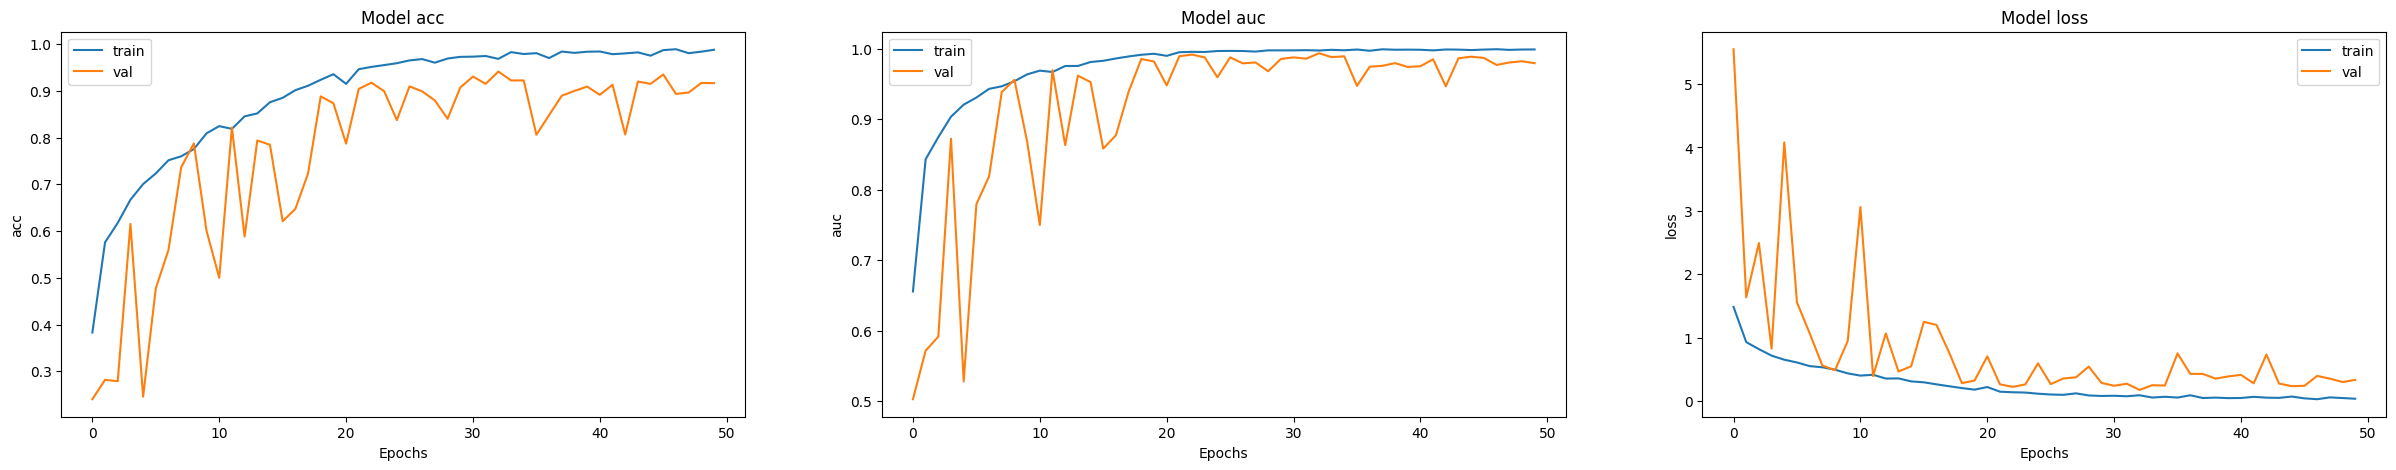

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

80/80 [==============================] - 1s 6ms/step


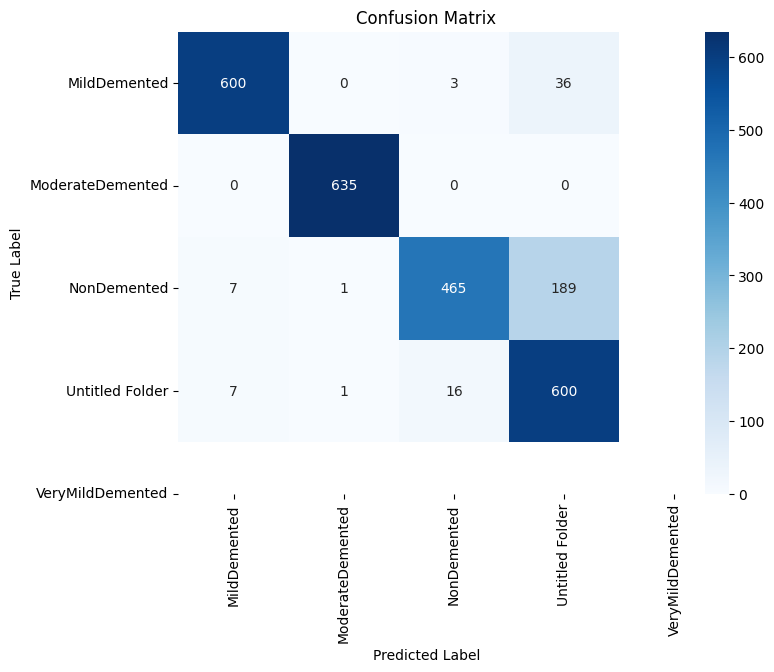

In [ ]:
# Convertendo as previsões para classes
test_predictions = model.predict(test_data)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(test_true_classes, test_predictions_classes)

# Plotando a matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculando métricas
accuracy = accuracy_score(test_true_classes, test_predictions_classes)
precision = precision_score(test_true_classes, test_predictions_classes, average='weighted')
recall = recall_score(test_true_classes, test_predictions_classes, average='weighted')
f1 = f1_score(test_true_classes, test_predictions_classes, average='weighted')

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Sensibilidade:", recall)
print("F1-Score:", f1)

Acurácia: 0.8984375
Precisão: 0.9169011036617022
Sensibilidade: 0.8984375
F1-Score: 0.8984250619168005


In [ ]:
inception = InceptionV3(input_shape=(128,128,3),include_top=False,weights ='imagenet')

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
inception_model = Sequential([
        inception,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "inception_cnn_model")
inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 dropout_5 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_101 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dense_4 (Dense)             (None, 512)       

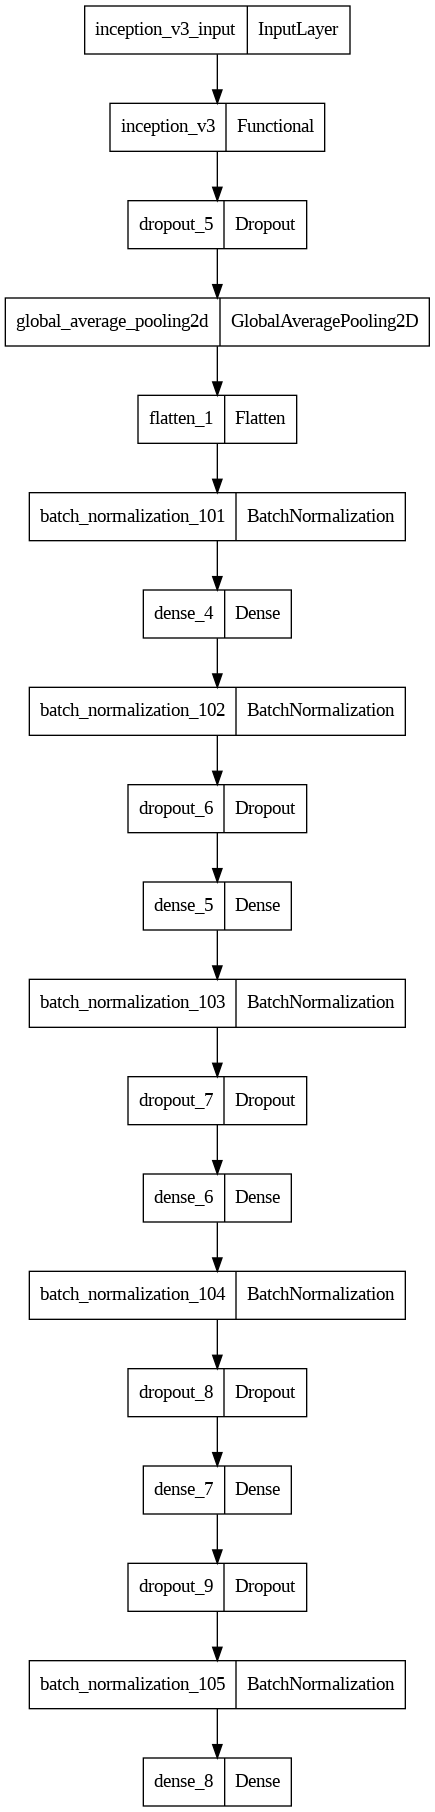

In [ ]:
plot_model(inception_model)

In [ ]:
INCEPT_CALLBACKS = [
    ModelCheckpoint(filepath='incpt_model_checkpoint.h5', save_best_only=True),
    EarlyStopping(patience=3)
]

In [ ]:
incept_history = inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50,callbacks= INCEPT_CALLBACKS)

Epoch 1/50
256/256 [==============================] - 20s 45ms/step - loss: 1.4139 - acc: 0.5153 - auc: 0.7820 - f1_score: 0.5140 - val_loss: 0.8298 - val_acc: 0.6172 - val_auc: 0.8736 - val_f1_score: 0.5539
Epoch 2/50
256/256 [==============================] - 6s 25ms/step - loss: 0.9703 - acc: 0.5552 - auc: 0.8278 - f1_score: 0.5415 - val_loss: 0.7335 - val_acc: 0.6377 - val_auc: 0.8966 - val_f1_score: 0.5747
Epoch 3/50
256/256 [==============================] - 7s 27ms/step - loss: 0.8530 - acc: 0.6099 - auc: 0.8667 - f1_score: 0.5922 - val_loss: 0.6773 - val_acc: 0.6758 - val_auc: 0.9130 - val_f1_score: 0.6517
Epoch 4/50
256/256 [==============================] - 7s 27ms/step - loss: 0.7878 - acc: 0.6454 - auc: 0.8866 - f1_score: 0.6342 - val_loss: 0.6579 - val_acc: 0.6870 - val_auc: 0.9175 - val_f1_score: 0.6711
Epoch 5/50
256/256 [==============================] - 7s 26ms/step - loss: 0.7575 - acc: 0.6658 - auc: 0.8958 - f1_score: 0.6554 - val_loss: 0.6143 - val_acc: 0.7202 - val

In [ ]:
incept_test_scores = inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(incept_test_scores[1] * 100))

80/80 [==============================] - 2s 19ms/step - loss: 0.3394 - acc: 0.8664 - auc: 0.9789 - f1_score: 0.8655
Testing Accuracy: 86.64%


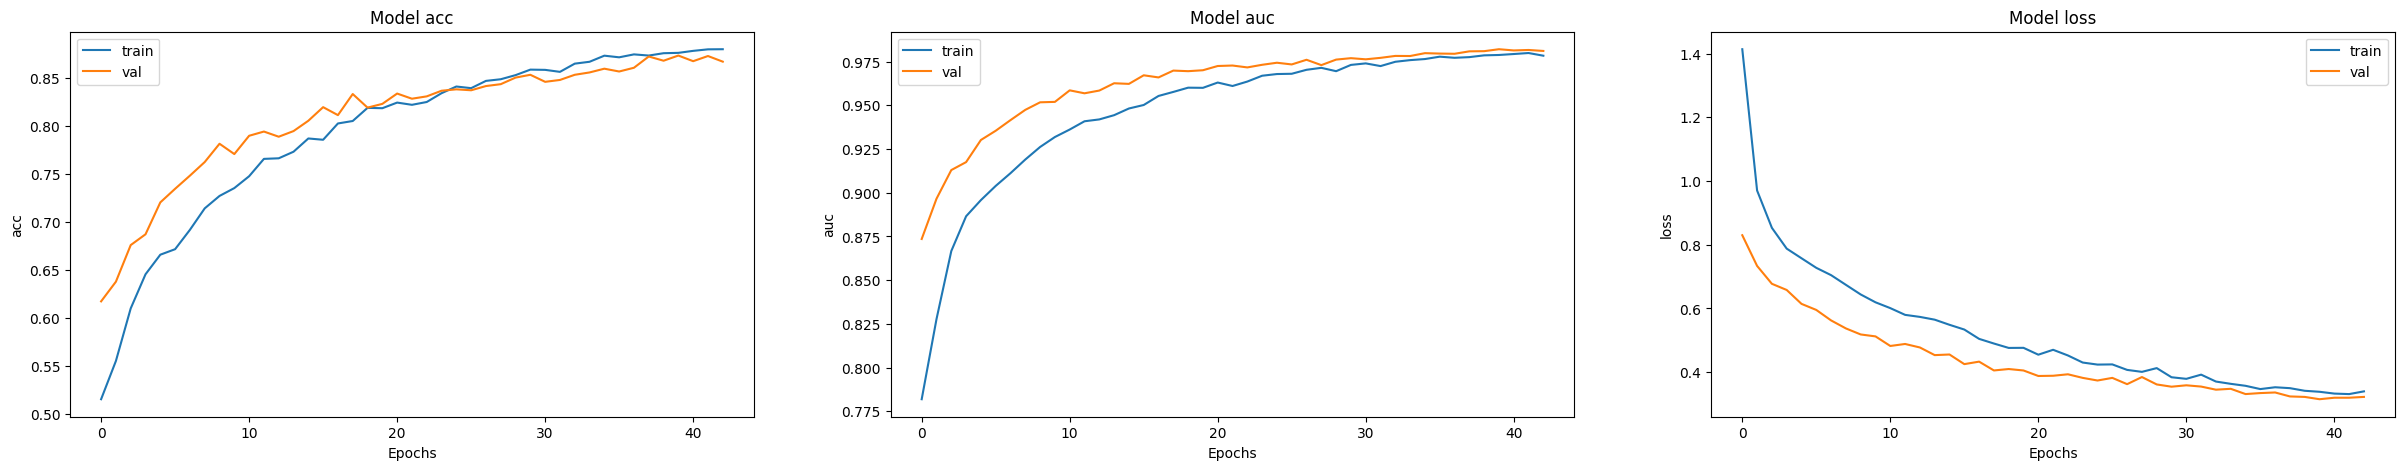

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(incept_history.history[metric])
    ax[i].plot(incept_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

80/80 [==============================] - 3s 18ms/step


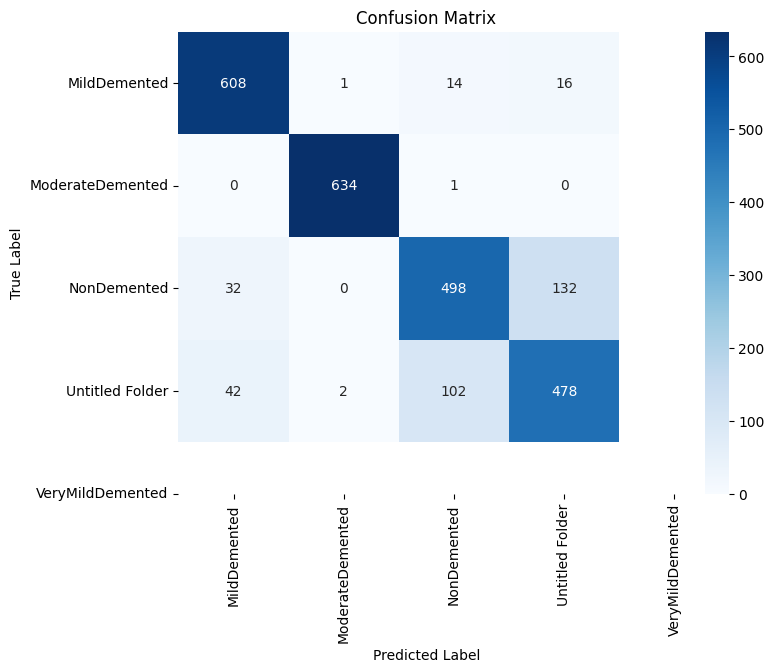

In [ ]:
# Convertendo as previsões para classes
test_predictions = inception_model.predict(test_data)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(test_true_classes, test_predictions_classes)

# Plotando a matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculando métricas
accuracy = accuracy_score(test_true_classes, test_predictions_classes)
precision = precision_score(test_true_classes, test_predictions_classes, average='weighted')
recall = recall_score(test_true_classes, test_predictions_classes, average='weighted')
f1 = f1_score(test_true_classes, test_predictions_classes, average='weighted')

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Sensibilidade:", recall)
print("F1-Score:", f1)

Acurácia: 0.86640625
Precisão: 0.8649244095069066
Sensibilidade: 0.86640625
F1-Score: 0.8651469426291147


In [ ]:
# entender o que ta colaborando, quais fatias sao usadas na classificação, shap
# o que que é um unidade que ele classifica, o que é uma linha do dataset uma fatia?
# verificar dados

In [ ]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import numpy as np
import shap
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# set batch size
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
# set transformation for training and validation
transform_train = transforms.Compose([
                transforms.Resize(size = (224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5946, 0.5732, 0.5126), std=(0.2671, 0.2737, 0.3058)) # use calculated mean and std
                ])

# # define data loader
# train_loader = torch.utils.data.DataLoader(train_data,
#                                            batch_size=TRAIN_BATCH_SIZE,
#                                            shuffle=True,
#                                            num_workers=4)
# test_loader = torch.utils.data.DataLoader(test_data,
#                                           batch_size=VAL_BATCH_SIZE,
#                                           shuffle=False,
#                                           num_workers=4)

# set transformation for SHAP visualization
base_transform = transforms.Compose([
                 transforms.Resize(size = (224, 224)),
                 transforms.ToTensor()
                 ])
# set dataset
base_dataset = datasets.ImageFolder("./dataset", transform=base_transform)
# define data loader
base_loader = torch.utils.data.DataLoader(base_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=4)

In [ ]:
batch = next(iter(base_loader))
images, labels = batch

background = images[:61].to(device)
test_images = images[61:64].to(device)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [ ]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().cpu().numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

AttributeError: ignored